# PDAN8412 POE Part 1
## LSTM-RNN

Link:
https://archive.ics.uci.edu/dataset/454/victorian+era+authorship+attribution 

## Setup Instructions

Before running this notebook, please ensure you have the following installed:

- **Python 3.10.x** (https://python.org)
- **Adoptium JDK 17** (https://adoptium.net/)

### 1. Create a Virtual Environment

Open your terminal in the project root directory and run:

```bash
python -m venv .venv
```

### 2. Activate the Virtual Environment

```bash
.\.venv\Scripts\activate
```

### 3. Install Python Dependencies

```bash
pip install --upgrade pip
pip install -r requirements.txt
```

### 4. (Optional) Register the Kernel for Jupyter

```bash
python -m ipykernel install --user --name pdan-env --display-name "Python (PDAN8412)"
```

### 5. Ensure JAVA_HOME is Set

Set the JAVA_HOME environment variable to your Adoptium JDK 17 installation path.

**Windows (Command Prompt):**
```bash
set JAVA_HOME=C:\Program Files\Eclipse Adoptium\jdk-17.x.x.x-hotspot
```


In [1]:
# all libraries contained inside .venv running on Python 3.10.8 and Adoptium JDK 17.0.16.8-hotspot
# Total venv file size ~5GB
!python -m pip install -r requirements.txt

In [2]:
# Imports
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, isnan, when, length, trim, regexp_replace
from pyspark.sql.types import *
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

print(f"PySpark version: {pyspark.__version__}")
print(f"TensorFlow version: {tf.__version__}")

PySpark version: 4.0.0
TensorFlow version: 2.20.0


In [3]:
# Config Objects
AUTHOR_COL = "author"
TEXT_COL = "text"

In [4]:
# Start the spark session
spark = SparkSession.builder \
    .appName("VictorianAuthorAttribution") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

print("Spark Session initialized successfully")
print(f"Spark Version: {spark.version}")

Spark Session initialized successfully
Spark Version: 4.0.0


In [5]:
# Load CSV files
print("Loading Data...\n")

# Load main dataset
try:
    df_test = spark.read.csv("data/Gungor_2018_VictorianAuthorAttribution_data.csv", header=True, inferSchema=True)
    print("Main dataset loaded successfully.")
    print(f"Columns: {df_test.columns}")
    print(f"Shape: {df_test.count(), len(df_test.columns)}")
except Exception as e:
    print(f"Error loading main dataset: {e}")
    df_test = None

# Load training dataset
try:
    df_train = spark.read.csv("data/Gungor_2018_VictorianAuthorAttribution_data-train.csv", header=True, inferSchema=True)
    print("Training dataset loaded successfully.")
    print(f"Columns: {df_train.columns}")
    print(f"Shape: {df_train.count(), len(df_train.columns)}")
except Exception as e:
    print(f"Error loading training dataset: {e}")
    df_train = None

# Exit early if either dataset fails to load
if df_test is None or df_train is None:
    raise RuntimeError("One or more datasets failed to load. Exiting...")

Loading Data...

Main dataset loaded successfully.
Columns: ['text']
Shape: (38809, 1)
Training dataset loaded successfully.
Columns: ['text', 'author']
Shape: (53678, 2)


In [6]:
# Data schema investigation
print("\nData schema investigation:")

if df_test:
    print("Test dataset schema:")
    df_test.printSchema()
    print("\nFirst 5 rows:")
    df_test.show(5, truncate=True)
if df_train:
    print("Training dataset schema:")
    df_train.printSchema()
    print("\nFirst 5 rows:")
    df_train.show(5, truncate=True)



Data schema investigation:
Test dataset schema:
root
 |-- text: string (nullable = true)


First 5 rows:
+--------------------+
|                text|
+--------------------+
|nt it seems te me...|
|to talk about why...|
|my foot on the gr...|
|hour or wait for ...|
|will not listen t...|
+--------------------+
only showing top 5 rows
Training dataset schema:
root
 |-- text: string (nullable = true)
 |-- author: integer (nullable = true)


First 5 rows:
+--------------------+------+
|                text|author|
+--------------------+------+
|ou have time to l...|     1|
|wish for solitude...|     1|
|and the skirt ble...|     1|
|of san and the ro...|     1|
|an hour s walk wa...|     1|
+--------------------+------+
only showing top 5 rows


In [7]:
# Row counts and basic statistics
print("Row counts and basic statistics")

if df_test:
    row_count_test = df_test.count()
    col_count_test = len(df_test.columns)
    print(f"Test Dataset: {row_count_test:,} rows × {col_count_test} columns")

if df_train:
    row_count_train = df_train.count()
    col_count_train = len(df_train.columns)
    print(f"Training Dataset: {row_count_train:,} rows × {col_count_train} columns")

# Compare datasets if both exist
if df_test and df_train:
    print(f"Difference: {row_count_train - row_count_test} rows")

Row counts and basic statistics
Test Dataset: 38,809 rows × 1 columns
Training Dataset: 53,678 rows × 2 columns
Difference: 14869 rows


In [8]:
# Author analysis
print("\nAuthor analysis:")

def analyse_authors(df, dataset_name):
    if df is None:
        return
    
    print(f"\n{dataset_name} Author Distribution:")

    # Check if author column exists
    if AUTHOR_COL not in df.columns:
        print(f"Author column not found in {dataset_name}.")
        return

    # Distinct authors
    distinct_authors = df.select(AUTHOR_COL).distinct().count()
    print(f"Distinct authors in {dataset_name}: {distinct_authors}")

    # Author distribution
    print("Top authors by document count:")
    author_distribution = df.groupBy(AUTHOR_COL).count().orderBy(desc("count"))
    author_distribution.show(truncate=False)



# Look at both datasets
print("\nComparing author distributions between datasets:")
analyse_authors(df_test, "Test Dataset")
analyse_authors(df_train, "Training Dataset")


Author analysis:

Comparing author distributions between datasets:

Test Dataset Author Distribution:
Author column not found in Test Dataset.

Training Dataset Author Distribution:
Distinct authors in Training Dataset: 45
Top authors by document count:
+------+-----+
|author|count|
+------+-----+
|8     |6914 |
|26    |4441 |
|14    |2696 |
|37    |2387 |
|45    |2312 |
|21    |2307 |
|39    |2266 |
|48    |1825 |
|33    |1742 |
|19    |1543 |
|4     |1483 |
|15    |1460 |
|43    |1266 |
|38    |1163 |
|25    |1159 |
|9     |1108 |
|18    |1078 |
|42    |1022 |
|30    |972  |
|50    |914  |
+------+-----+
only showing top 20 rows


In [9]:
# Text content analysis
print("\nText content analysis:")

def analyse_text_content(df, dataset_name):
    if df is None:
        return
    
    print(f"\n{dataset_name} Text Content Analysis:")

    df_add_length = df.withColumn("text_length", length(col(TEXT_COL)))

    # text statistics
    text_stats = df_add_length.select(
        F.min("text_length").alias("min_length"),
        F.max("text_length").alias("max_length"),
        F.mean("text_length").alias("mean_length"),
        F.stddev("text_length").alias("stddev_length")
    ).collect()[0]

    print(f"  Text Length Statistics:")
    print(f"    Min Length: {text_stats['min_length']}")
    print(f"    Max Length: {text_stats['max_length']}")
    print(f"    Mean Length: {text_stats['mean_length']}")
    print(f"    Stddev Length: {text_stats['stddev_length']}")

    # Check for empty text
    empty_text_count = df.filter((col(TEXT_COL).isNull()) | (trim(col(TEXT_COL)) == "")).count()
    print(f"  Empty/null Text Count: {empty_text_count}")

    # Check for extremely short/long texts
    very_short = df.filter(length(col(TEXT_COL)) < 100).count()
    very_long = df.filter(length(col(TEXT_COL)) > 10000).count()
    print(f"  Very Short Texts (<100 chars): {very_short}")
    print(f"  Very Long Texts (>10000 chars): {very_long}")

    # Check for excessive whitespace
    excessive_whitespace_count = df.filter(length(trim(col(TEXT_COL))) == 0).count()
    print(f"  Excessive Whitespace Count: {excessive_whitespace_count}")


analyse_text_content(df_train, "Training Dataset")
analyse_text_content(df_test, "Test Dataset")


Text content analysis:

Training Dataset Text Content Analysis:
  Text Length Statistics:
    Min Length: 2286
    Max Length: 5760
    Mean Length: 4942.966913819442
    Stddev Length: 249.79725188625974
  Empty/null Text Count: 0
  Very Short Texts (<100 chars): 0
  Very Long Texts (>10000 chars): 0
  Excessive Whitespace Count: 0

Test Dataset Text Content Analysis:
  Text Length Statistics:
    Min Length: 2278
    Max Length: 6410
    Mean Length: 4985.830322863253
    Stddev Length: 247.36270039601473
  Empty/null Text Count: 0
  Very Short Texts (<100 chars): 0
  Very Long Texts (>10000 chars): 0
  Excessive Whitespace Count: 0


In [11]:
def _find_text_col(df):
    candidates = [c for c in df.columns if any(k in c.lower() for k in ("text","content","txt","piece","document"))]
    return candidates[0] if candidates else None

def to_pandas_with_length(spark_df, text_col, author_col=None, sample_frac=None, seed=42):
    df = spark_df.withColumn("text_length", length(trim(text_col)))
    if sample_frac:
        df = df.sample(withReplacement=False, fraction=sample_frac, seed=seed)
    cols = [text_col, "text_length"] + ([author_col] if author_col and author_col in spark_df.columns else [])
    pdf = df.select(*cols).toPandas()
    pdf["text_length"] = pdf["text_length"].astype(int)
    return pdf

# identify text and author columns (fall back to constants if present)
text_col_train = _find_text_col(df_train) if 'df_train' in globals() else None
text_col_test  = _find_text_col(df_test)  if 'df_test' in globals() else None
author_col = AUTHOR_COL if AUTHOR_COL in (df_train.columns if 'df_train' in globals() else []) else None

# convert to pandas for visualisation
pdf_train = to_pandas_with_length(df_train, text_col_train if text_col_train else TEXT_COL, author_col)
pdf_test  = to_pandas_with_length(df_test,  text_col_test  if text_col_test  else TEXT_COL, None)


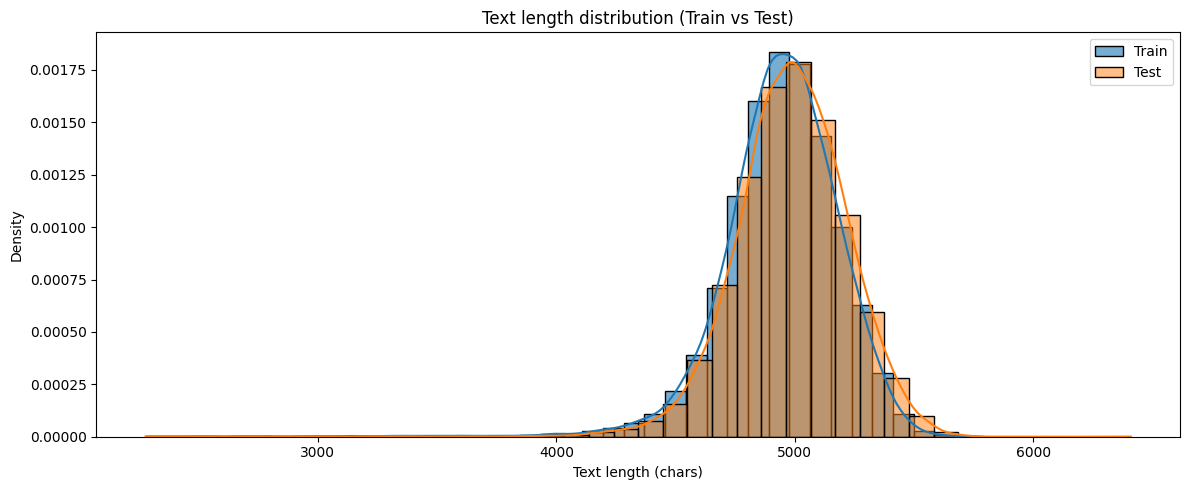

In [12]:
# Histogram + KDE of text lengths (train vs test)
plt.figure(figsize=(12,5))
sns.histplot(pdf_train["text_length"], bins=40, color="C0", stat="density", kde=True, label="Train", alpha=0.6)
sns.histplot(pdf_test["text_length"],  bins=40, color="C1", stat="density", kde=True, label="Test",  alpha=0.5)
plt.title("Text length distribution (Train vs Test)")
plt.xlabel("Text length (chars)")
plt.legend()
plt.tight_layout()
plt.show()

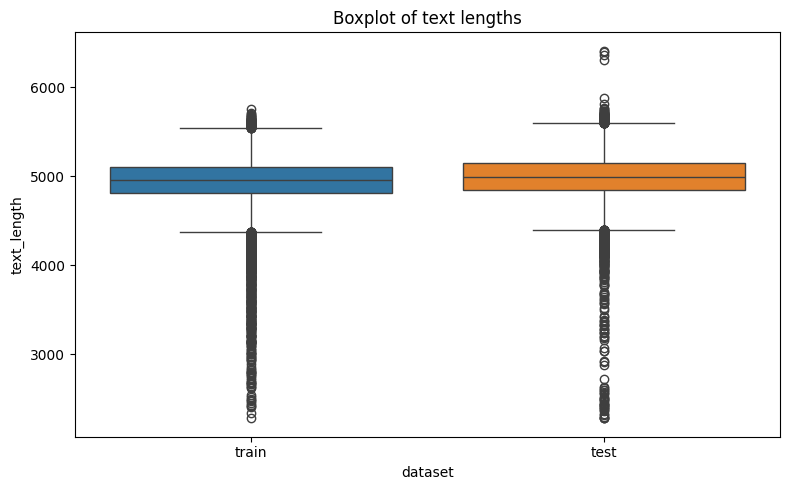

In [13]:
# Boxplot comparisons
plt.figure(figsize=(8,5))
combined = pd.DataFrame({
    "text_length": pd.concat([pdf_train["text_length"], pdf_test["text_length"]], ignore_index=True),
    "dataset": ["train"]*len(pdf_train) + ["test"]*len(pdf_test)
})
sns.boxplot(x="dataset", y="text_length", data=combined, palette=["C0","C1"])
plt.title("Boxplot of text lengths")
plt.tight_layout()
plt.show()

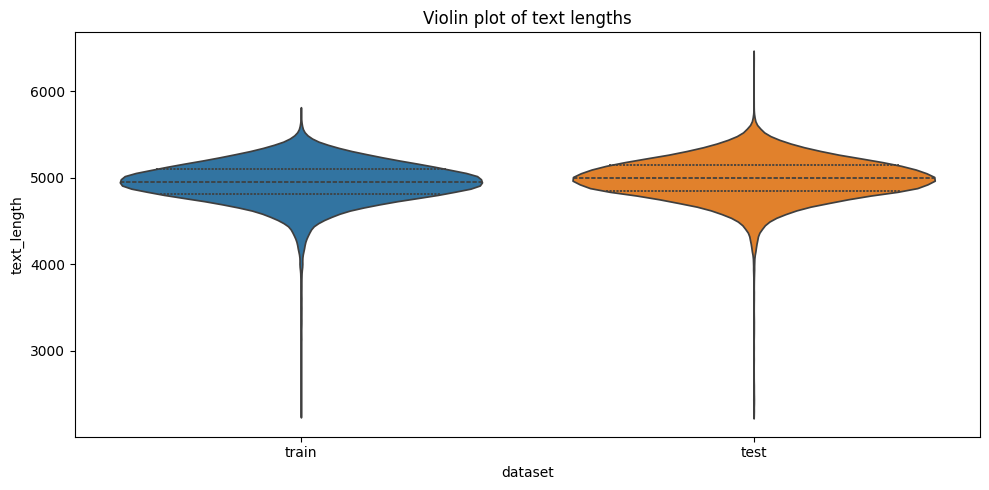

In [14]:
# Violin and swarm plots
plt.figure(figsize=(10,5))
sns.violinplot(x="dataset", y="text_length", data=combined, inner="quartile", palette=["C0","C1"])
plt.title("Violin plot of text lengths")
plt.tight_layout()
plt.show()

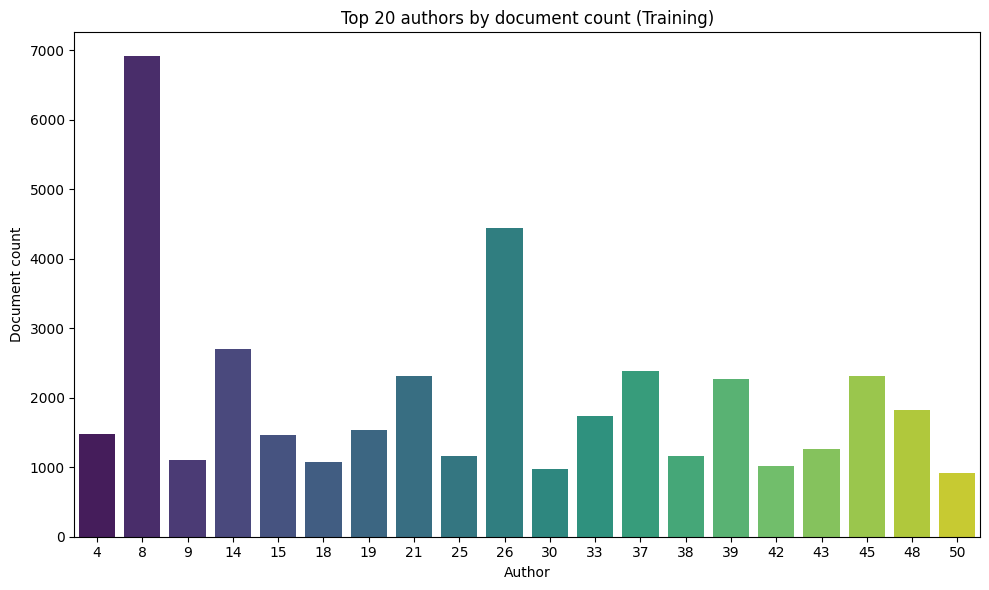

In [19]:
# Per author doc counts from train set
top_authors = (df_train.groupBy(author_col).count()
               .orderBy(F.desc("count"))
               .limit(20)
               .toPandas()
               .sort_values("count"))
plt.figure(figsize=(10,6))
sns.barplot(x=author_col, y="count", data=top_authors, palette="viridis")
plt.title("Top 20 authors by document count (Training)")
plt.xlabel("Author")
plt.ylabel("Document count")
plt.tight_layout()
plt.show()


In [16]:
# Data Quality Checks
print("\nData Quality Checks:")

def print_quality_summary(df, dataset_name):
    if df is None:
        return
    
    print(f"\n{dataset_name} Quality Summary:")

    total_rows = df.count()

    # Check data completeness
    complete_rows = df.filter(
        col(AUTHOR_COL).isNotNull() & col(TEXT_COL).isNotNull()
        & (trim(col(TEXT_COL)) != "")
    ).count()

    completeness_rate = (complete_rows / total_rows * 100) if total_rows > 0 else 0
    print(f"  Data Completeness: {completeness_rate:.2f}%")

    if completeness_rate < 95:
        print("  Warning: Data completeness is below 95%")
    else:
        print("  Success: Data completeness is acceptable.")

print_quality_summary(df_train, "Training Dataset")
# Can't run quality summary on test dataset as it is only text as a column

print("\nData loading and initial analysis complete.")


Data Quality Checks:

Training Dataset Quality Summary:
  Data Completeness: 100.00%
  Success: Data completeness is acceptable.

Data loading and initial analysis complete.
